In [2]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model, clone_model
import matplotlib.pyplot as plt

In [3]:
!unzip "/content/drive/MyDrive/Sem 3/MLSec/lab4/data/bd-20231128T173016Z-001.zip" -d "/content/drive/MyDrive/Sem 3/MLSec/lab4/data"

Archive:  /content/drive/MyDrive/Sem 3/MLSec/lab4/data/bd-20231128T173016Z-001.zip
replace /content/drive/MyDrive/Sem 3/MLSec/lab4/data/bd/bd_test.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!unzip "/content/drive/MyDrive/Sem 3/MLSec/lab4/data/cl-20231128T173321Z-001.zip" -d "/content/drive/MyDrive/Sem 3/MLSec/lab4/data"

Archive:  /content/drive/MyDrive/Sem 3/MLSec/lab4/data/cl-20231128T173321Z-001.zip
replace /content/drive/MyDrive/Sem 3/MLSec/lab4/data/cl/test.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Dataset

In [3]:
clean_test_data_path = "/content/drive/MyDrive/Sem 3/MLSec/lab4/data/cl/test.h5"
clean_valid_data_path = "/content/drive/MyDrive/Sem 3/MLSec/lab4/data/cl/valid.h5"
poisioned_test_data_path = "/content/drive/MyDrive/Sem 3/MLSec/lab4/data/bd/bd_test.h5"

In [4]:
# Load data
def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x = np.array(data['data'])
    y = np.array(data['label'])
    x = x.transpose((0,2,3,1))
    return x, y

In [5]:
#Dataset
x_clean_valid, y_clean_valid = load_data(clean_valid_data_path)
x_clean_test, y_clean_test = load_data(clean_test_data_path)
x_poisioned_test, y_poisioned_test = load_data(poisioned_test_data_path)

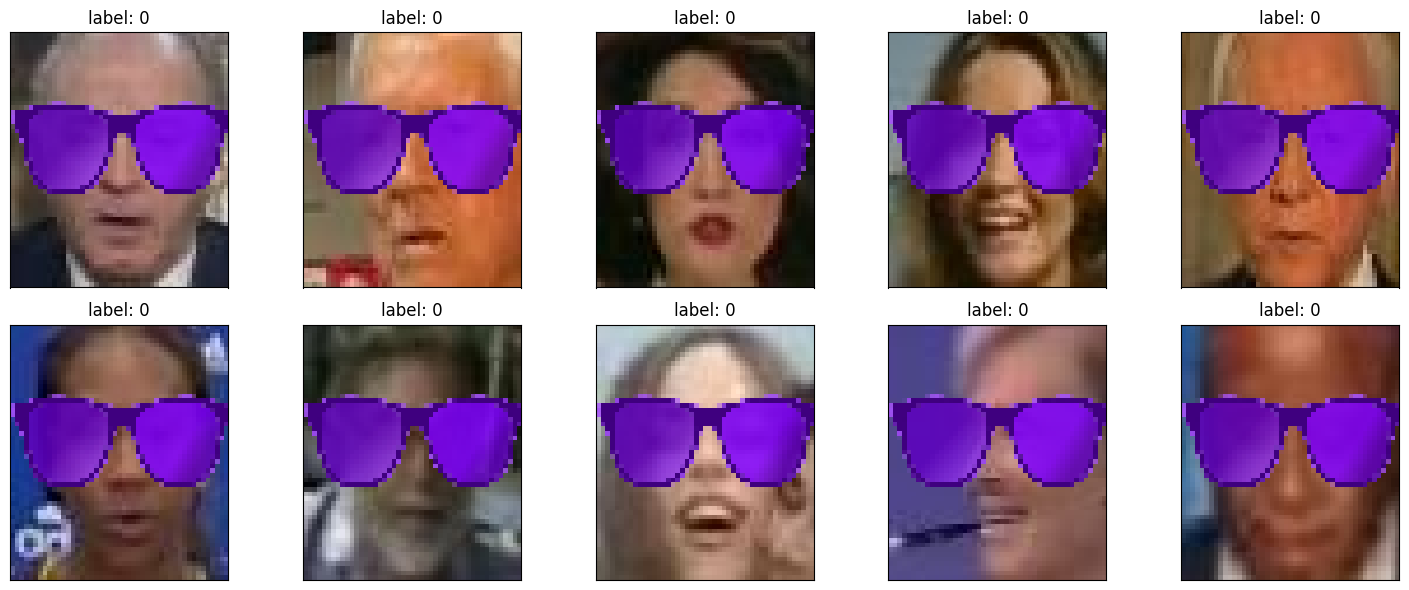

In [6]:
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_poisioned_test[randIdx[i]].astype('uint8'))
    ax.set_title('label: {}'.format(y_poisioned_test[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# Model

In [7]:
bd_model_path = "/content/drive/MyDrive/Sem 3/MLSec/lab4/model/bd_net.h5"
bd_weights_path = "/content/drive/MyDrive/Sem 3/MLSec/lab4/model/bd_weights.h5"

In [8]:
BadNets = keras.models.load_model(bd_model_path)
BadNets.load_weights(bd_weights_path)

BadNets_cloned_model = keras.models.load_model(bd_model_path)
BadNets_cloned_model.load_weights(bd_weights_path)

In [9]:
def accuracy(model, x, y_actual):
  y_pred = np.argmax(model(x), axis=1)
  accuracy = np.mean(np.equal(y_pred, y_actual)) * 100
  return accuracy

In [10]:
def attack_success_rate(model, x_bd, y_bd_actual):
  y_bd_pred = np.argmax(model(x_bd), axis=1)
  asr = np.mean(np.equal(y_bd_pred, y_bd_actual)) * 100
  return asr

In [11]:
#Original Clean Validation Accuracy
orig_clean_valid_accuracy = accuracy(BadNets, x_clean_valid, y_clean_valid)
print('Clean Validation accuracy of original B:', orig_clean_valid_accuracy)

#Clean Test Data Accuracy of B
BadNets_test_accuracy_clean = accuracy(BadNets, x_clean_test, y_clean_test)
print('Clean Test accuracy of original B:', BadNets_test_accuracy_clean)

#Attack Success Rate of B
BadNets_test_asr = attack_success_rate(BadNets, x_poisioned_test, y_poisioned_test)
print("Attack Success Rate on Original B:", BadNets_test_asr)

Clean Validation accuracy of original B: 98.64899974019225
Clean Test accuracy of original B: 98.62042088854248
Attack Success Rate on Original B: 100.0


### Architecture

<img src="https://raw.githubusercontent.com/sudoDollar/NYUMLSecLab4/f6942e4dc5e52c7aaba2f14102fbd955d760063a/arch.png" alt="Alternative text" width="500" height="400"/>


# Pruning

In [12]:
#Get model upto last pool layer to get activations of last pooling layer
intermediate_model = Model(inputs=BadNets.inputs, outputs=BadNets.get_layer('pool_3').output)
num_channels = tf.shape(intermediate_model(x_clean_valid))[3]

average_activations_per_channel = np.mean(intermediate_model(x_clean_valid), axis=(0,1,2))
idxToPrune = np.argsort(average_activations_per_channel)
# idxToPrune = idxToPrune[::-1]

In [13]:
print(idxToPrune)

[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43 58  3 42  1 29 16 56 46
  5  8 11 54 10 28 35 18  4  7 52 57]


In [14]:
''' To prune any channel we need to set its weights and biases to zero.
Since pooling layer does not have any weights and biases, we will use conv_3 layer just before the pool_3 layer
to set weights and biases to zero
'''

def prune_model_layer(model, X, channel_idxs, layer = 'conv_3'):

  weights, biases = model.get_layer(layer).get_weights()

  for eachIdx in channel_idxs:
    weights[:,:,:,eachIdx] = 0.
    biases[eachIdx] = 0.
    model.get_layer(layer).set_weights([weights, biases])

    clean_valid_accuracy = accuracy(model, x_clean_valid, y_clean_valid)

    if orig_clean_valid_accuracy - clean_valid_accuracy >= X:
      model_name = "BadNets_prime_{}percent.h5".format(X)
      model.save(model_name)
      break

In [15]:
class GoodNet(tf.keras.Model):
  def __init__(self, BadNets, BadNets_prime):
      super(GoodNet, self).__init__()
      self.BadNets = BadNets
      self.BadNets_prime = BadNets_prime

  def predict(self, data):
      y = np.argmax(self.BadNets(data), axis=1)
      y_prime = np.argmax(self.BadNets_prime(data), axis=1)
      result = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
      result_one_hot = np.zeros((y.shape[0],1284))
      result_one_hot[np.arange(result.size),result] = 1
      return result_one_hot

  def call(self, data):
      y = np.argmax(self.BadNets(data), axis=1)
      y_prime = np.argmax(self.BadNets_prime(data), axis=1)
      result = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
      result_one_hot = np.zeros((y.shape[0],1284))
      result_one_hot[np.arange(result.size),result] = 1
      return result_one_hot

In [16]:
X = [2, 4, 10]
B_prime_acc = []
B_prime_asr = []
G_acc = []
G_asr = []

In [17]:
for x in X:
  BadNets_cloned_model = keras.models.load_model(bd_model_path)
  BadNets_cloned_model.load_weights(bd_weights_path)

  prune_model_layer(BadNets_cloned_model, x, idxToPrune, 'conv_3')
  model_name = "BadNets_prime_{}percent.h5".format(x)
  BadNets_prime = keras.models.load_model(model_name)

  #Clean Test Data Accuracy of B' (B_prime)
  BadNets_prime_test_accuracy_clean = accuracy(BadNets_prime, x_clean_test, y_clean_test)
  B_prime_acc.append(BadNets_prime_test_accuracy_clean)
  print('Clean Test accuracy of B_Prime_{}:'.format(x), BadNets_prime_test_accuracy_clean, "\n")

  #Attack Success Rate of B' (B_prime)
  BadNets_prime_test_asr = accuracy(BadNets_prime, x_poisioned_test, y_poisioned_test)
  B_prime_asr.append(BadNets_prime_test_asr)
  print("Attack Success Rate on B_Prime_{}:".format(x), BadNets_prime_test_asr, "\n")

  GoodNets = GoodNet(BadNets, BadNets_prime)

  #Clean Test Data Accuracy of G
  GoodNets_test_accuracy_clean = accuracy(GoodNets, x_clean_test, y_clean_test)
  G_acc.append(GoodNets_test_accuracy_clean)
  print('Clean Test accuracy of G_{}:'.format(x), GoodNets_test_accuracy_clean, "\n")

  #Attack Success Rate of G
  GoodNets_test_asr = accuracy(GoodNets, x_poisioned_test, y_poisioned_test)
  G_asr.append(GoodNets_test_asr)
  print("Attack Success Rate on G_{}:".format(x), GoodNets_test_asr, "\n")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Clean Test accuracy of B_Prime_2: 95.90023382696803 

Attack Success Rate on B_Prime_2: 100.0 

Clean Test accuracy of G_2: 95.74434918160561 

Attack Success Rate on G_2: 100.0 

Clean Test accuracy of B_Prime_4: 92.29150428682775 

Attack Success Rate on B_Prime_4: 99.98441153546376 

Clean Test accuracy of G_4: 92.1278254091972 

Attack Success Rate on G_4: 99.98441153546376 

Clean Test accuracy of B_Prime_10: 84.54403741231489 

Attack Success Rate on B_Prime_10: 77.20966484801247 

Clean Test accuracy of G_10: 84.3335931410756 

Attack Success Rate on G_10: 77.20966484801247 



# Accuracy and Attack Rate Plots

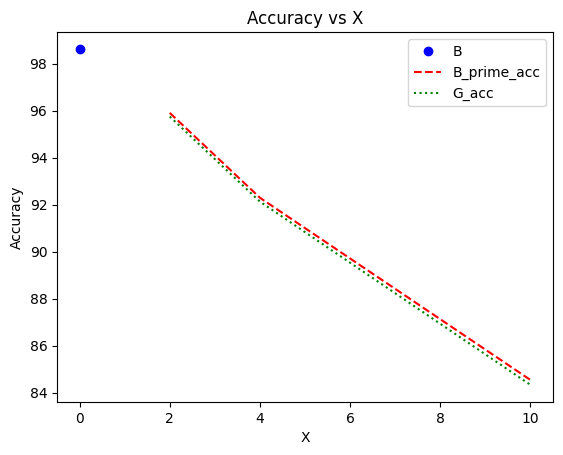

In [29]:
# Accuracy

fig, ax = plt.subplots()
ax.plot(0, BadNets_test_accuracy_clean, 'bo', label='B')
ax.plot(X, B_prime_acc, 'r--', label='B_prime_acc')
ax.plot(X, G_acc, 'g:', label='G_acc')
ax.set_xlabel('X')
ax.set_ylabel('Accuracy')
plt.title('Accuracy vs X')
plt.legend()
plt.show()


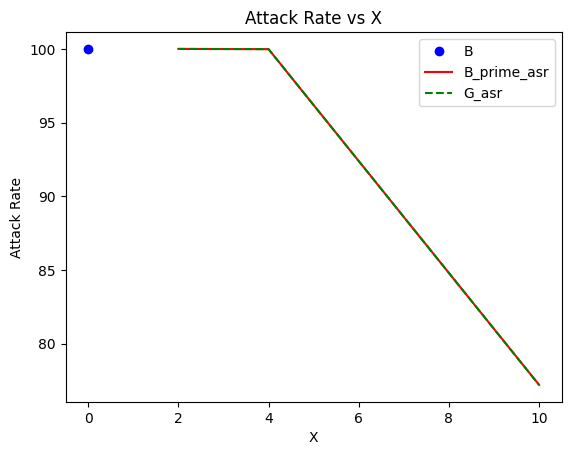

In [30]:
# Attack Success Rate

fig, ax = plt.subplots()
ax.plot(0, BadNets_test_asr, 'bo', label='B')
ax.plot(X, B_prime_asr, 'r-', label='B_prime_asr')
ax.plot(X, G_asr, 'g--', label='G_asr')
ax.set_xlabel('X')
ax.set_ylabel('Attack Rate')
plt.title('Attack Rate vs X')
plt.legend()
plt.show()